### Problem Statement
- You're a data scientist at Ford GoBike (https://www.fordgobike.com/), the company running Bay Area Bikeshare. You are trying to increase ridership, and you want to offer deals through the mobile app to do so. What deals do you offer though? Currently, your company has three options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual membership.

- Through this project, you will answer these questions:

    - What are the 5 most popular trips that you would call "commuter trips"?
    - What are your recommendations for offers (justify based on your findings)?

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

**Let us first run the query to get the size of the dataset**

In [15]:
!bq query --use_legacy_sql=false --format=csv 'SELECT count(*) as number_of_trips FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > dataset_size.csv
data_size = pd.read_csv('dataset_size.csv')
print("")
print("Total number of rows in the trips dataset is %d" %(data_size.number_of_trips))

Waiting on bqjob_r1aebc3980e5e691d_00000168cb907946_1 ... (0s) Current status: DONE   
Total number of rows in the trips dataset is 983648


## What are the 5 most popular trips that you would call "commuter trips"?

To answer this we can define commuter trip as a trip which has different start station and end station. Which would mean the bike was used to go from one place to the other such as from home to work rather than used by tourist who will generally drop the bike on the same station from where she/he rented the bike. To get the number of such trips we can run the count with the where clause where the start_station_name != end_station_name. 
Now, To get the 5 most popular trips we would need to run the count and group by start_station_name and end_station_name for the rows which satisfies the where condition start_station_name != end_station_name

What I did was in the webquery ran the following SQL and then saved the results as a table called **commuter_trips_count**
```sql
SELECT start_station_name,
       end_station_name,
       count(*) as Number_of_commuter_trips
 FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_name != end_station_name
GROUP BY start_station_name,
         end_station_name
```
Now,to get the 5 most popular commuter trips we can run query against this table

In [16]:
!bq query --use_legacy_sql=false --format=csv 'SELECT start_station_name,end_station_name,Number_of_commuter_trips FROM `flowing-depot-228714.bike_trip_data.commuter_trips_count` ORDER BY Number_of_commuter_trips DESC LIMIT 5' > pop_trips.csv
pop_trips=pd.read_csv('pop_trips.csv')

Waiting on bqjob_r31c7a85d2a8dfdb6_00000168cb9098d3_1 ... (0s) Current status: DONE   

Now, Let us print the 5 most popular trips amongst the commuters

In [17]:
pop_trips.iloc[:,0:2]

,start_station_name,end_station_name
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building)
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend
4,Embarcadero at Sansome,Steuart at Market


# Reccomendations 

- Let us find which 20 zip codes have the least customers from but have at least 1000 customers

In [18]:
!bq query --use_legacy_sql=false --format=csv 'SELECT zip_code,count(*) number_of_cust FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY zip_code HAVING number_of_cust > 1000 ORDER BY number_of_cust LIMIT 20' > unpopular_zip.csv
unpopular_zip_codes = pd.read_csv('unpopular_zip.csv')
unpopular_zip_codes

Waiting on bqjob_ra0892176dcf0062_00000168cb90be91_1 ... (0s) Current status: DONE   

,zip_code,number_of_cust
0,94518,1024
1,94556,1038
2,94577,1050
3,94539,1053
4,95122,1060
5,95148,1086
6,94601,1086
7,94947,1092
8,94534,1095
9,94587,1151


**Recommendation: The above 20 zip codes are the ones which have critical mass of customers but the ridership can be increased. To acheive this I propose to create a referral program in these zip codes where customers who refer friends to Ford GoBike would receive coupons and discounts. This will make the bikes popular in these areas where the penetration is less.**

- For Commuter trips let us find out how is the distribution of the trips across months 

In [19]:
!bq query --use_legacy_sql=false --format=csv 'SELECT EXTRACT(MONTH FROM START_DATE) AS MONTH_NUMBER,COUNT(*) as NUMBER_OF_TRIPS FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE START_STATION_NAME != END_STATION_NAME GROUP BY MONTH_NUMBER ORDER BY MONTH_NUMBER' > Monthly_commuter_rides.csv 
Monthly_Commuter_trips = pd.read_csv('Monthly_commuter_rides.csv')
Monthly_Commuter_trips

Waiting on bqjob_r18a6525b28647d80_00000168cb90d628_1 ... (0s) Current status: DONE   

,MONTH_NUMBER,NUMBER_OF_TRIPS
0,1,69748
1,2,68000
2,3,79234
3,4,81834
4,5,83565
5,6,88816
6,7,86441
7,8,92268
8,9,83564
9,10,91151


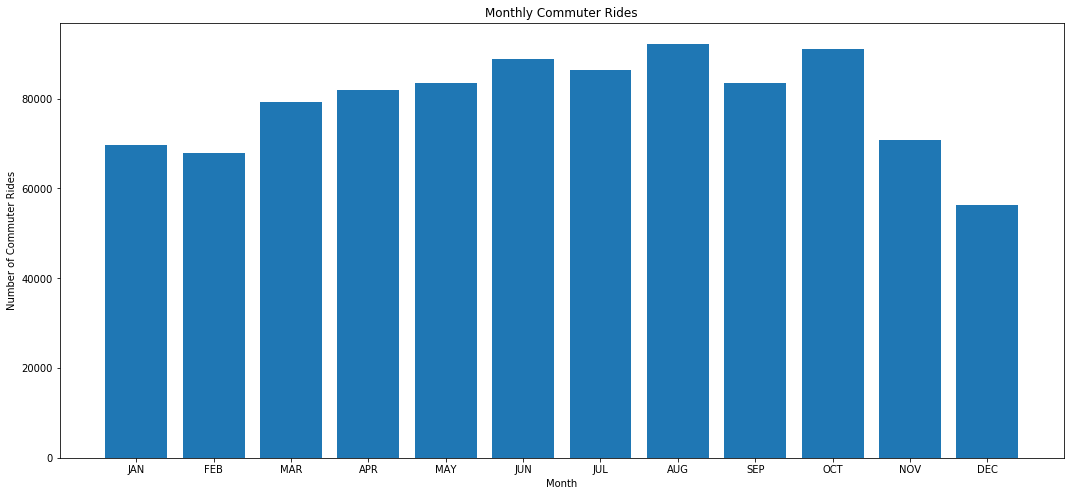

In [20]:
fig = plt.figure(figsize=(18,8))
plt.bar(x=Monthly_Commuter_trips.MONTH_NUMBER, height=Monthly_Commuter_trips.NUMBER_OF_TRIPS,align='center')
plt.xlabel("Month")
plt.xticks(Monthly_Commuter_trips.MONTH_NUMBER,('JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'))
plt.ylabel("Number of Commuter Rides")
plt.title("Monthly Commuter Rides")
plt.show()

**Recommendation: We see from the graph that december month has the least ridership for commuters. Which makes sense as its holiday season and riders would be on vacation. 
But what we also see is that there are months which have less trips than August which has the maximum number of trips. To encourage the Ridership in other months Ford Go Bike should target the months such as March,April May to have discounts on trips so that ridership can increase.**

- Let us find out about the customer type for commuters

In [21]:
!bq query --use_legacy_sql=false --format=csv 'SELECT subscriber_type,count(*) as number  FROM `bigquery-public-data.san_francisco.bikeshare_trips` where start_station_name != end_station_name group by subscriber_type' > subscriber_type.csv
Customer_type_count = pd.read_csv('subscriber_type.csv')
Customer_type_count

Waiting on bqjob_r65421faef3038922_00000168cb911d48_1 ... (0s) Current status: DONE   

,subscriber_type,number
0,Subscriber,836945
1,Customer,114656


We see that most of the commuters are yearly or monthly subscriber. Let us find out how many commuter trips are between 0 to 15 mins and number between 15 to 30 mins 

In [22]:
!bq query --use_legacy_sql=false --format=csv 'SELECT SUM(IF(duration_sec < 900,1,0)) trips_between_0_15_mins,SUM(IF(duration_sec >= 900 and duration_sec < 1800,1,0)) trips_between_15_30_mins FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE start_station_name != end_station_name and duration_sec < 1800' > short_trip_count.csv
trip_count = pd.read_csv('short_trip_count.csv')
trip_count

Waiting on bqjob_r122bfe69bfcb6234_00000168cb914b20_1 ... (0s) Current status: DONE   

,trips_between_0_15_mins,trips_between_15_30_mins
0,816897,103956


**Recommendation: What we see is that most of the commuter trips are short between 0 to 30 mins and especially 0 to 15 mins. But most of the commuters have annual or monthly subscription. It will be a good business plan to introduce low cost daily unlimited rides for commuters so that they increase number of trips. Per trip might become cheaper because of this but due to increase in volume of trips there would be net gain in revenue**

# Summary

- We found that following are the **5 most popular trips amongst commuters**

|start_station_name	|end_station_name|
|:-------------------:|:----------------:|
|Harry Bridges Plaza (Ferry Building)|	Embarcadero at Sansome|
|San Francisco Caltrain 2 (330 Townsend)	|Townsend at 7th||
|2nd at Townsend	|Harry Bridges Plaza (Ferry Building)|
|Harry Bridges Plaza (Ferry Building)|	2nd at Townsend|
|Embarcadero at Sansome	|Steuart at Market|

- **Recommendations:** Based on the data queried following are the recommendations to the Ford Go Bike
    - Create a referral program in the 20 zip codes listed above where customers who refer friends to Ford GoBike would receive coupons and discounts. This will make the bikes popular in these areas where the penetration is less.
    
    - To encourage the Ridership in lean months Ford Go Bike should target the months such as March,April May to have discounts on trips so that ridership can increase.
    
    - Introduce low cost daily unlimited rides for commuters so that there is increase number of trips. Per trip might become cheaper because of this but due to increase in volume of trips there would be net gain in revenue.
